In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import csv

In [ ]:
tf.__version__

'2.4.0'

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
bitcoin_21month = pd.read_csv('/content/drive/MyDrive/BTCUSDT-21months.csv')

bitcoin_21month['Timestamp'] = pd.to_datetime(bitcoin_21month['Timestamp'], unit='s')
bitcoin_21month = bitcoin_21month.set_index(['Timestamp'])
bitcoin_21month.interpolate(method='time', inplace=True)

bitcoin_21month['Close'] = bitcoin_21month['Close'].fillna(method='ffill')
bitcoin_21month['Weighted_Price'] = bitcoin_21month['Weighted_Price'].fillna(method='ffill')
bitcoin_21month['Volume_(BTC)'] = bitcoin_21month['Volume_(BTC)'].fillna(0)
bitcoin_21month['Volume_(USDT)'] = bitcoin_21month['Volume_(USDT)'].fillna(0)
bitcoin_21month['Open'] = bitcoin_21month['Open'].fillna(bitcoin_21month['Close'])
bitcoin_21month['High'] = bitcoin_21month['High'].fillna(bitcoin_21month['Close'])
bitcoin_21month['Low'] = bitcoin_21month['Low'].fillna(bitcoin_21month['Close'])

In [ ]:
test_df = bitcoin_21month.iloc[-86400:]
train_df = bitcoin_21month.iloc[-(86400 + 7 * 86400): -86400]

train_df_norm = (train_df - train_df.mean()) / train_df.std()
valid_df_norm = train_df_norm.iloc[-(len(train_df_norm))//5:]
train_df_norm = train_df_norm.iloc[-(len(train_df_norm))//5*4:]
test_df_estimate_norm = (test_df - train_df.iloc[-86400:].mean()) / train_df.iloc[-86400:].std()

In [ ]:
n_features = len(train_df_norm.columns)
window_size = 60
forecast_size = 60
batch_size = 64
buffer_size = 64
model_dim = 64
num_heads = 8
num_hidden_neurons = 512

In [ ]:
    def multivariate_data(dataset, target, start_index,
            end_index, history_size, target_size,
            step, single_step=True):
        data = []
        labels = []

        start_index = start_index + history_size
        if end_index is None:
            end_index = len(dataset - target_size)

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            if i + target_size < len(dataset):
                data.append(dataset[indices])

                if single_step:
                    labels.append(target[i+target_size])
                else:
                    labels.append(target[i:i+target_size])
            else:
                pass

        return np.array(data), np.array(labels)

In [ ]:
train_x, train_y = multivariate_data(train_df_norm.values, train_df_norm.values[:,6], 0, None, 60, 60, 1)
val_x, val_y = multivariate_data(valid_df_norm.values, valid_df_norm.values[:,6], 0, None, 60, 60, 1)
test_x, test_y = multivariate_data(test_df_estimate_norm.values, test_df_estimate_norm.values[:,6], 0, None, 60, 60, 1)

In [ ]:
train_x = train_x[:, :, 6]
val_x = val_x[:, :, 6]
test_x = test_x[:, :, 6]

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.Q_layer = tf.keras.layers.Dense(model_dim)
        self.K_layer = tf.keras.layers.Dense(model_dim)
        self.V_layer = tf.keras.layers.Dense(model_dim)
        self.linear_layer = tf.keras.layers.Dense(model_dim)

    def calculate_attention(self, q, k, v, mask):
        qk = tf.matmul(q, k, transpose_b=True)
        score = qk / tf.cast(tf.shape(k)[-1], tf.float32)
        if mask is not None:
            score = tf.math.multiply(mask, score)
        weights = tf.nn.softmax(score, axis=-1)
        output = tf.matmul(weights, v)
        return output, weights

    def split(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, model_dim//self.num_heads))
        return tf.transpose(x, perm=[0, 2, 1])

    def call(self, q, k=None, v=None, mask=None, training=True):
        if k==None and v==None:
            k = q
            v = q
        batch_size = tf.shape(q)[0]
        q = self.Q_layer(q, training=training)
        k = self.K_layer(k, training=training)
        v = self.V_layer(v, training=training)

        # q = self.split(q, batch_size)
        # k = self.split(k, batch_size)
        # v = self.split(v, batch_size)

        att, weights = self.calculate_attention(q, k, v, mask)
        output = tf.transpose(att, perm=[0, 2, 1])
        concat_att = tf.reshape(output, (batch_size, -1, self.model_dim))
        output = self.linear_layer(concat_att, training=training)

        return weights

In [ ]:
# inputs1 = tf.keras.layers.Input(shape=(60, 7))
inputs = tf.keras.layers.Input(shape=(60, 1))
# att_layer = tf.keras.layers.MultiHeadAttention(model_dim, num_heads)(inputs, inputs)
attention = tf.keras.layers.MultiHeadAttention(model_dim, num_heads)(inputs, inputs)
dropout = tf.keras.layers.Dropout(0.1)(attention)
norm = tf.keras.layers.BatchNormalization()(dropout)
d1 = tf.keras.layers.Dense(num_hidden_neurons, activation='relu')(norm)
d2 = tf.keras.layers.Dense(model_dim)(d1)
norm2 = tf.keras.layers.BatchNormalization()(d2)
outputs = tf.keras.layers.Dense(1)(norm2)
tst_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
tst_model = tf.keras.Sequential()
tst_model.add(MultiHeadAttention(model_dim, num_heads))
tst_model.add(tf.keras.layers.Dropout(0.1))
tst_model.add(tf.keras.layers.BatchNormalization())
tst_model.add(tf.keras.layers.Dense(num_hidden_neurons, activation='relu'))
tst_model.add(tf.keras.layers.Dense(model_dim))
tst_model.add(tf.keras.layers.Dense(1))

In [ ]:
tst_model.build(input_shape=(None, 60, 1))
tst_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
multi_head_attention_7 (Mult (None, 60, 60)            4544      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 60)            240       
_________________________________________________________________
dense_44 (Dense)             (None, 60, 512)           31232     
_________________________________________________________________
dense_45 (Dense)             (None, 60, 64)            32832     
_________________________________________________________________
dense_46 (Dense)             (None, 60, 1)             65        
Total params: 68,913
Trainable params: 68,793
Non-trainable params: 120
________________________________________________

In [ ]:
tst_model.compile(optimizer='adam', loss='mse')
tst_model.fit(train_x, train_y, epochs=20, batch_size=64)

Epoch 1/20
7559/7559 [==============================] - 61s 8ms/step - loss: 0.0654
Epoch 2/20
7559/7559 [==============================] - 60s 8ms/step - loss: 0.0440
Epoch 3/20
7559/7559 [==============================] - 58s 8ms/step - loss: 0.0438
Epoch 4/20
7559/7559 [==============================] - 58s 8ms/step - loss: 0.0431
Epoch 5/20
7559/7559 [==============================] - 59s 8ms/step - loss: 0.0430
Epoch 6/20
7559/7559 [==============================] - 58s 8ms/step - loss: 0.0427
Epoch 7/20
7559/7559 [==============================] - 59s 8ms/step - loss: 0.0429
Epoch 8/20
7559/7559 [==============================] - 59s 8ms/step - loss: 0.0426
Epoch 9/20
7559/7559 [==============================] - 58s 8ms/step - loss: 0.0422
Epoch 10/20
7559/7559 [==============================] - 58s 8ms/step - loss: 0.0422
Epoch 11/20
7559/7559 [==============================] - 59s 8ms/step - loss: 0.0427
Epoch 12/20
7559/7559 [==============================] - 58s 8ms/step - lo

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_fun = tf.keras.losses.MeanSquaredError()

def loss(tst_model, x, y, training):
    y_ = tst_model(x, training=training)

    return loss_fun(y_true=y, y_pred=y_)

def grad(tst_model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(tst_model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, tst_model.trainable_variables)

train_loss_results = []
train_accuracy_results = []

num_epochs = 20
for epoch in range(num_epochs):
    epoch_loss = tf.keras.metrics.MeanSquaredError()

    for i in range(len(train_x)//batch_size):
        loss_value, grads = grad(tst_model, train_x[i*batch_size:(i+1)*batch_size],
                                train_y[i*batch_size:(i+1)*batch_size])
        optimizer.apply_gradients(zip(grads, tst_model.trainable_variables))
        epoch_loss.update_state(train_y[i*batch_size:(i+1)*batch_size], tst_model(train_x[i*batch_size:(i+1)*batch_size], training=True))
    train_loss_results.append(epoch_loss)
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss.result()))

KeyboardInterrupt: ignored

In [ ]:
y_pred = tst_model.predict(test_x)

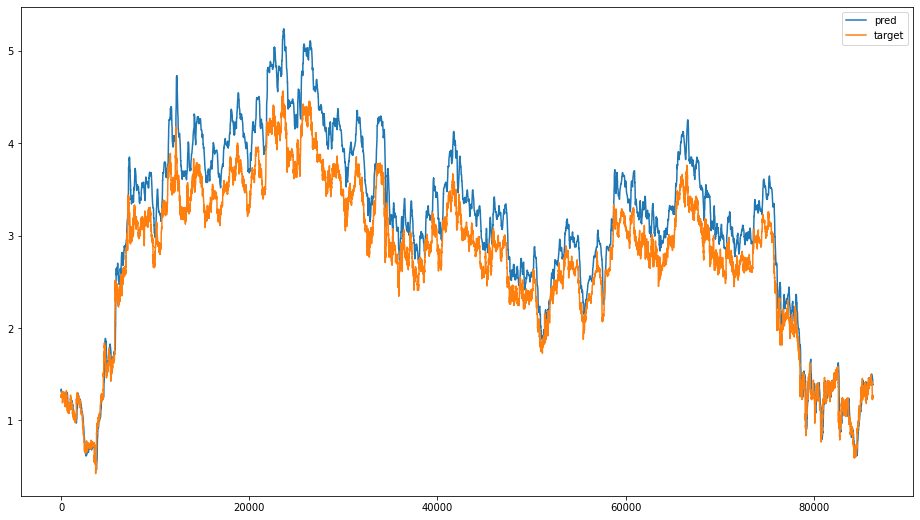

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(y_pred[:, 59, :], label='pred')
plt.plot(test_y, label='target')
plt.legend(loc=0)